Implement the DBSCAN algorithm. Run the algorithm with the following Eps and MinPts values:

1. dataset1.txt: Eps ∈ {0.2, 0.3, 0.4}, M inP ts ∈ {2, 3, 4}
2. dataset2.txt: Eps ∈ {0.8, 0.85, 0.9}, M inP ts ∈ {6, 7, 8}
3. dataset3.txt: Eps ∈ {0.2, 0.3, 0.4}, M inP ts ∈ {5, 6, 7}

Report the following information:
1. Make tables for the NMI, CH index and SC values as a function of Eps and MinPts.

2. For the best result (based on NMI) make a scatter plot in which different shapes are used to show the true label, and different colors represent the learned cluster assignments. Noise points should be given a special color.

 Reference: http://scikitlearn.org/stable/auto_examples/cluster/plot_dbscan.html

In [52]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import metrics
from sklearn.metrics.cluster import normalized_mutual_info_score 

In [53]:
dataSets = ['datasets/dataset1.txt', 'datasets/dataset2.txt', 'datasets/dataset3.txt']

In [54]:
# checks if point 'p' is in neighbourhood of point 'q'
def inNeighbourhood(p, q, eps):
    return np.linalg.norm(p - q) < eps

# returns a list of directly density reachable points
def getNeighbouringPoints(feature_matrix, pointID, eps):
    neighbouringPoints = []
    for index in range(feature_matrix.shape[0]):
        if inNeighbourhood(feature_matrix[pointID], feature_matrix[index], eps):
            neighbouringPoints.append(index)
    return neighbouringPoints

# perform dbscan on all neighbouring points and classify them
def expandCluster(feature_matrix, dbscanLabels, pointID, clusterID, eps, minPts):
    neighbouringPoints = getNeighbouringPoints(feature_matrix, pointID, eps)
    if len(neighbouringPoints) < minPts:
        dbscanLabels[pointID] = -1 # classify the point as noise
        return False
    else: # this points and all its neighbouring points belong to same cluster
        dbscanLabels[pointID] = clusterID
        for pt in neighbouringPoints:
            dbscanLabels[pt] = clusterID
            
        while len(neighbouringPoints) > 0:
            currentPointID = neighbouringPoints[0]
            newNeighbours = getNeighbouringPoints(feature_matrix, currentPointID, eps)
            # check if currentPointID is a core point
            if len(newNeighbours) >= minPts:
                for i in range(0, len(newNeighbours)):
                    result_point = newNeighbours[i]
                    if dbscanLabels[result_point] in (False, -1): # noise or unclassified at this moment
                        if dbscanLabels[result_point] == False:
                            neighbouringPoints.append(result_point)
                        dbscanLabels[result_point] = clusterID
            neighbouringPoints = neighbouringPoints[1:] # using this list of queue
        return True

# perform DBSCAN of feature_matrix w.r.t eps and minPts
def DBSCAN(feature_matrix, eps, minPts):    
    clusterID = 1
    dbscanLabels = [False] * feature_matrix.shape[0]
    for pointID in range(feature_matrix.shape[0]):    
        if dbscanLabels[pointID] == False: # unclassified point
            if expandCluster(feature_matrix, dbscanLabels, pointID, clusterID, eps, minPts):
                clusterID = clusterID + 1
    return dbscanLabels

In [55]:
# returns feature_matrix(points) and true clusters for those points
def formatDataset(inputDataSet):    
    dataset = np.loadtxt(inputDataSet)
    feature_matrix = dataset[:, :-1]
    trueClusters = dataset[:,2]
    return feature_matrix, trueClusters

In [56]:
# plots different clusters in different colors

def plotClusters(plotID, feature_matrix, dbscanLabels, trueLabels, eps, minPts):
    
    feature1 = feature_matrix[:, 0]
    feature2 = feature_matrix[:, 1]
    
    colors = ['blue', 'gold', 'green', 'red', 'cyan', 'magenta', 'dimgrey', 'saddlebrown', 'purple', 'lime', 'peru', 'lightcoral']
    clusterColours = [colors[label] if label!=-1 else 'black' for label in dbscanLabels]
    
    shapes = ['.', 'o', 'D', '^', 'x']
    clusterShapes = [shapes[int(label)] for label in trueLabels]
        
    plt.subplot(plotID)
    
    for i in range(len(feature_matrix)):
        plt.scatter(feature1[i], feature2[i], marker=clusterShapes[i], s=40, lw=0, alpha=0.7, color=clusterColours[i])        
        
    pltTitle = "Eps = $%0.3f$ MinPts = $%d$" %(eps, minPts)
    plt.title(pltTitle)
    plt.xlabel("X")
    plt.ylabel("Y")    

In [57]:
def applyDBSCAN(feature_matrix, trueClusters, EpsList, MinPtsList):  
       
    evaluationMetrics = []
    CH = []
    SC = []
    NMI = []
    
    plt.figure(1)
    plt.figure(1).set_size_inches(6, 18)
    i = 311
    
    for eps, minPts in zip(EpsList, MinPtsList):
   
        dbscanLabels = DBSCAN(feature_matrix, eps, minPts)
        
        plotClusters(i, feature_matrix, dbscanLabels, trueClusters, eps, minPts)
        i=i+1
        
        NMI.append(metrics.normalized_mutual_info_score(trueClusters, dbscanLabels))
        SC.append(metrics.silhouette_score(feature_matrix, dbscanLabels, metric='euclidean'))
        CH.append(metrics.calinski_harabaz_score(feature_matrix, dbscanLabels))

    plt.show()

    evaluationMetrics.append(NMI)
    evaluationMetrics.append(SC)
    evaluationMetrics.append(CH)
    
    return evaluationMetrics

In [58]:
# plots line graph of different evaluation metrics
metricLabels = ['NMI', 'SC', 'CH']

def evaluateClusters(EpsList, MinPtsList, evaluationMetrics):  
    plt.figure(1)
    plt.figure(1).set_size_inches(18, 5)
    i = 131
    for metric in evaluationMetrics:        
        plt.subplot(i)        
        plt.plot(range(1, len(EpsList)+1), metric)
        plt.title(metricLabels[i-131])
        i=i+1
    plt.show()

In [59]:
import texttable as tt
def plotTable(EpsList, MinPtsList, evaluationMetrics):
    t = tt.Texttable()
    t.header(['Eps', 'MinPts', 'NMI', 'SC', 'CH'])
    for i in range(0, len(EpsList)):
        t.add_row([EpsList[i], MinPtsList[i], evaluationMetrics[0][i], evaluationMetrics[1][i], evaluationMetrics[2][i]])
    print(t.draw())

In [60]:
def runDBSCAN(dataSet, EpsList, MinPtsList) :
    feature_matrix, trueClusters = formatDataset(dataSet)
    evaluationMetrics = applyDBSCAN(feature_matrix, trueClusters, EpsList, MinPtsList)
    plotTable(EpsList, MinPtsList, evaluationMetrics)
    evaluateClusters(EpsList, MinPtsList, evaluationMetrics)    

# Analysis of DataSet-1

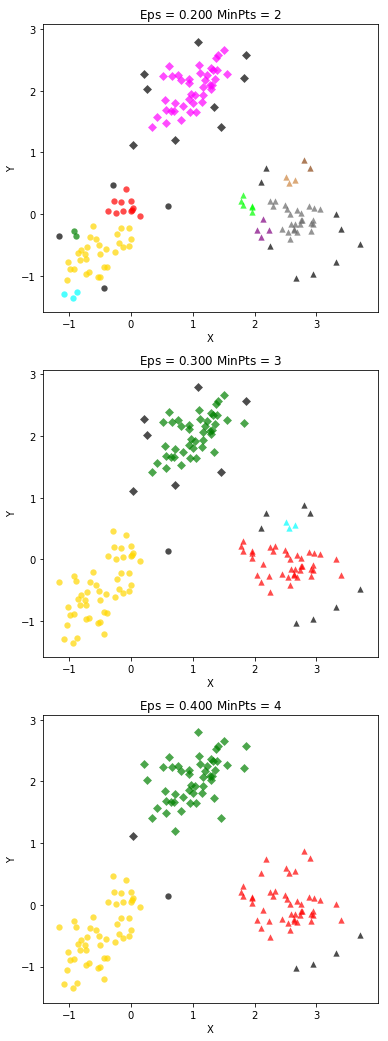

+-------+--------+-------+-------+---------+
|  Eps  | MinPts |  NMI  |  SC   |   CH    |
+=======+========+=======+=======+=========+
| 0.200 | 2      | 0.646 | 0.279 | 56.399  |
+-------+--------+-------+-------+---------+
| 0.300 | 3      | 0.813 | 0.455 | 175.987 |
+-------+--------+-------+-------+---------+
| 0.400 | 4      | 0.918 | 0.648 | 344.058 |
+-------+--------+-------+-------+---------+


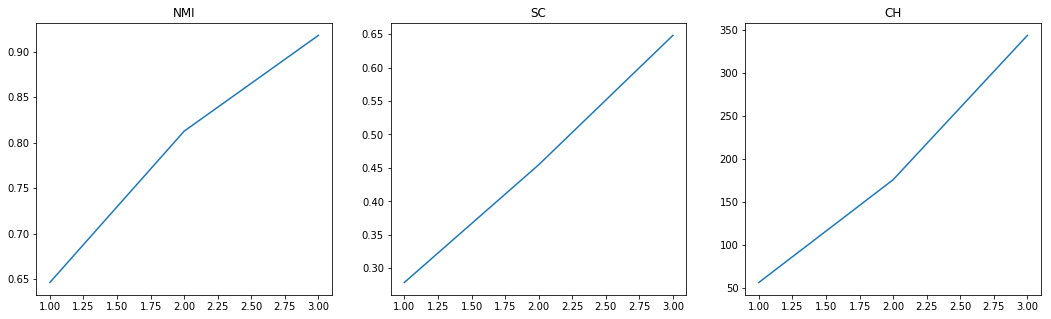

In [61]:
EpsList = [0.2, 0.3, 0.4]
MinPtsList = [2, 3, 4]
runDBSCAN(dataSets[0], EpsList, MinPtsList)

# Analysis of DataSet-2

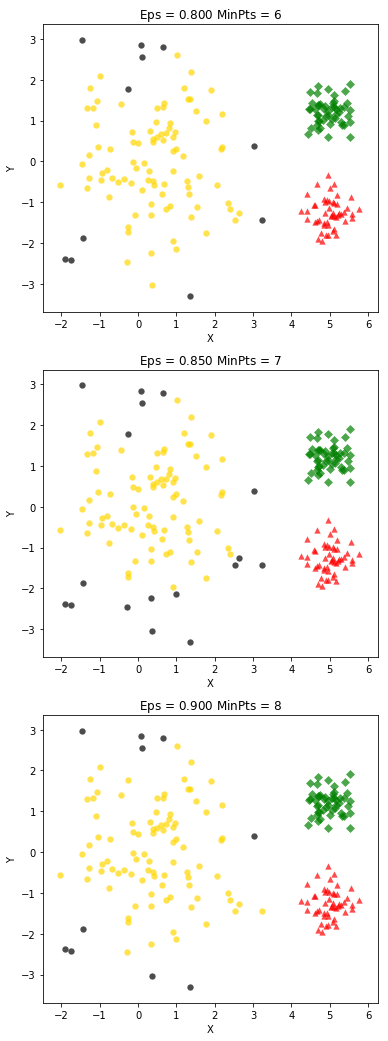

+-------+--------+-------+-------+---------+
|  Eps  | MinPts |  NMI  |  SC   |   CH    |
+=======+========+=======+=======+=========+
| 0.800 | 6      | 0.926 | 0.523 | 236.815 |
+-------+--------+-------+-------+---------+
| 0.850 | 7      | 0.906 | 0.519 | 243.498 |
+-------+--------+-------+-------+---------+
| 0.900 | 8      | 0.930 | 0.529 | 238.505 |
+-------+--------+-------+-------+---------+


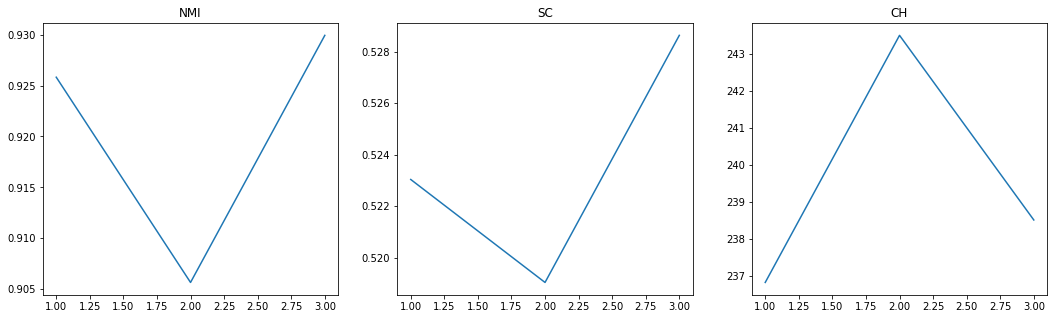

In [62]:
EpsList = [0.8,0.85,0.9]
MinPtsList = [6, 7, 8]
runDBSCAN(dataSets[1], EpsList, MinPtsList)

# Analysis of DataSet-3

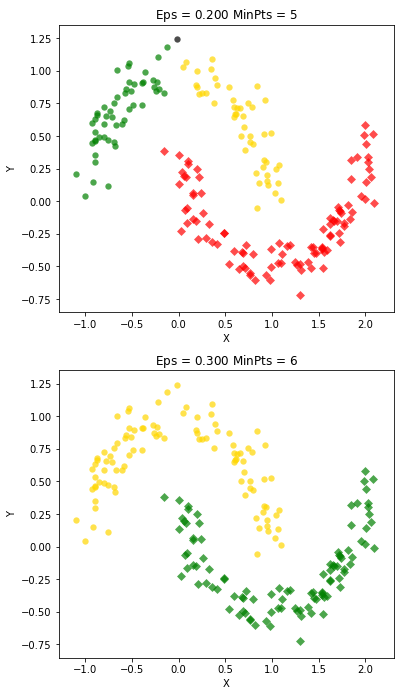

+-------+--------+-------+-------+---------+
|  Eps  | MinPts |  NMI  |  SC   |   CH    |
+=======+========+=======+=======+=========+
| 0.200 | 5      | 0.807 | 0.255 | 123.947 |
+-------+--------+-------+-------+---------+
| 0.300 | 6      | 1     | 0.362 | 162.813 |
+-------+--------+-------+-------+---------+


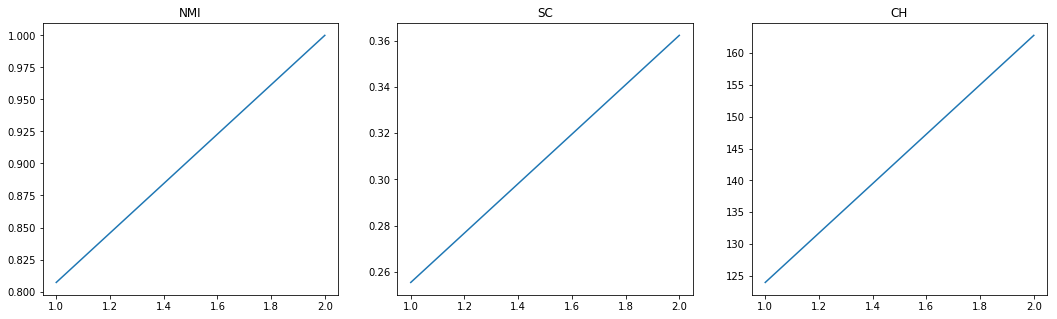

In [63]:
EpsList = [0.2, 0.3]
MinPtsList = [5, 6]
runDBSCAN(dataSets[2], EpsList, MinPtsList)

<h3>NOTE: for third combination of EPS and MinPts, there is only 1 cluster. So, the metrics from Sklearn throw the following Error: <h>
<h4>ValueError: Number of labels is 1.<h4>

ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

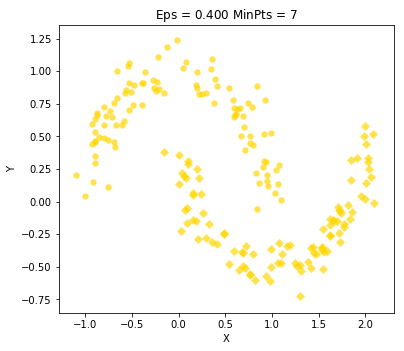

In [64]:
EpsList = [0.4]
MinPtsList = [7]
runDBSCAN(dataSets[2], EpsList, MinPtsList)